In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import numpy as np
import sys
from dotenv import load_dotenv

load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")


import warnings
warnings.filterwarnings("ignore")

In [ ]:
project = hopsworks.login(
    project='airquality',  # Replace with your project name
    host="eu-west.cloud.hopsworks.ai",
    port=443,
    api_key_value=HOPSWORKS_API_KEY  
)

In [4]:
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

In [5]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [6]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2026-02-05 20:23:54,116 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [7]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://eu-west.cloud.hopsworks.ai:443/p/4234/fs/5204/fv/air_quality_fv/version/1


In [9]:
# Parameters: Read from environment variables with defaults
test_days = 30
min_train_days = 180

print(f"Training parameters:")
print(f"  Test days: {test_days}")
print(f"  Minimum training days: {min_train_days}")

# Read data to determine available date range
print(f"\nCalculating train/test split with test_days={test_days}...")
query = feature_view.query
df_temp = query.read()

if df_temp.empty:
    raise ValueError("No data available in feature view")

# Ensure date column is datetime
df_temp['date'] = pd.to_datetime(df_temp['date'])

# Sort by date to find the most recent available data
df_temp_sorted = df_temp.sort_values('date')

# Get the most recent date in the available data
max_date = df_temp_sorted['date'].max()
min_date = df_temp_sorted['date'].min()
total_days = (max_date - min_date).days

print(f"Data available from {min_date.date()} to {max_date.date()} ({total_days} days)")

# Calculate test_start date: take the last test_days from the most recent available date
test_start = max_date - timedelta(days=test_days - 1)  # -1 to include max_date in test set

# Calculate actual training days
train_days = (test_start - min_date).days

print(f"Proposed split:")
print(f"  Training: {min_date.date()} to {test_start.date()} ({train_days} days)")
print(f"  Testing:  {test_start.date()} to {max_date.date()} ({test_days} days)")

# Validation: Check if we have enough training data
if train_days < min_train_days:
    raise ValueError(
        f"Insufficient training data. Requested {test_days} test days leaves only "
        f"{train_days} training days, but minimum {min_train_days} required. "
        f"Total available: {total_days} days. "
        f"Try reducing test_days or min_train_days."
    )

print(f"\nUsing test_start date: {test_start.date()}")

Training parameters:
  Test days: 30
  Minimum training days: 180

Calculating train/test split with test_days=30...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.68s) 
Data available from 2016-02-10 to 2026-02-06 (3649 days)
Proposed split:
  Training: 2016-02-10 to 2026-01-08 (3620 days)
  Testing:  2026-01-08 to 2026-02-06 (30 days)

Using test_start date: 2026-01-08


In [10]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.45s) 
2026-02-05 20:33:19,022 INFO: Computing insert statistics
2026-02-05 20:33:19,034 INFO: Computing insert statistics


In [13]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2016-02-10,-1.666333,0.0,19.813087,281.672668
1,2016-02-11,-2.174667,0.0,14.759999,293.347656
2,2016-02-12,-1.933000,0.7,10.383987,79.577225
3,2016-02-13,-2.130917,0.0,18.668005,310.573242
4,2016-02-14,-5.260083,0.0,14.658676,12.556378
...,...,...,...,...,...
3518,2026-01-03,5.927083,3.1,12.632101,40.568867
3519,2026-01-04,4.495833,0.0,8.274128,325.483337
3520,2026-01-05,4.641666,0.0,13.229693,138.149567
3521,2026-01-06,9.456249,0.0,19.091883,228.445831


In [14]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [17]:
#y_train

## <span style="color:#ff5f27;"> Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [18]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 228.92462
R squared: -0.4675072636024562


In [20]:
df = y_test
df['predicted_pm25'] = y_pred

In [21]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
3523,30.0,34.236370,2026-01-08
3524,31.0,26.250563,2026-01-09
3525,50.0,38.991905,2026-01-10
3526,31.0,27.516499,2026-01-11
3527,7.0,28.729065,2026-01-12


In [22]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [23]:

def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['date']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

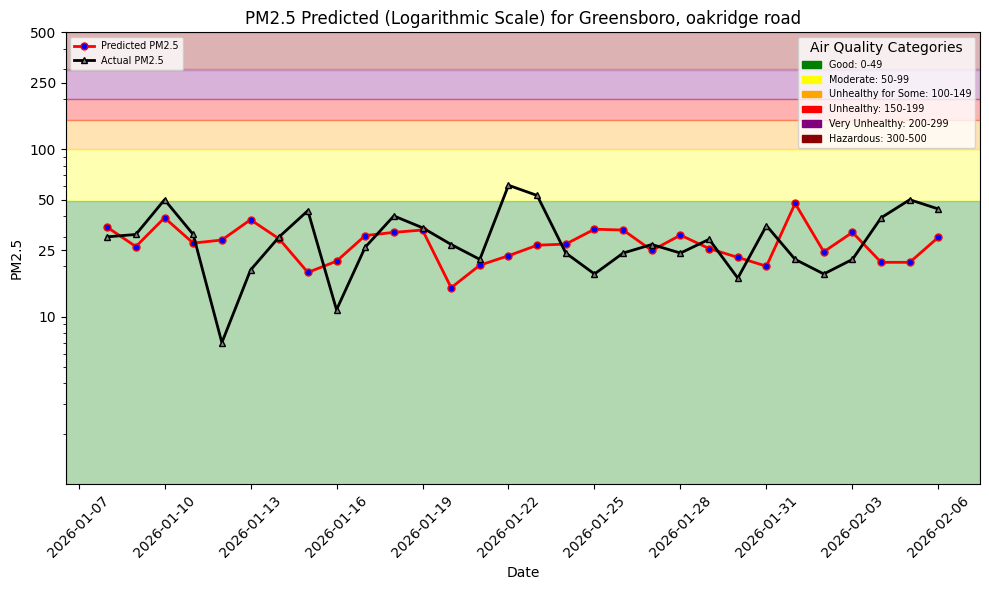

In [28]:
file_path = images_dir + "/pm25_hindcast.png"
plt = plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

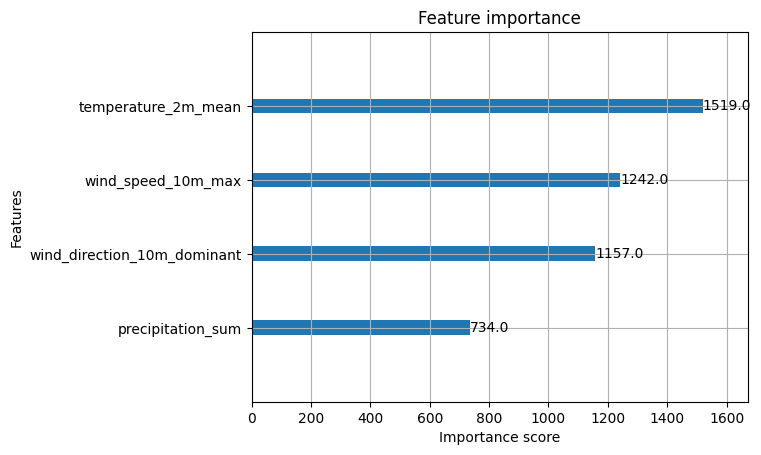

In [29]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [30]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [32]:
# Storing training results/metrics in a dictionary

res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2) if not np.isnan(r2) else "0.0",
        "test_days": str((pd.to_datetime(X_test['date']).max() - pd.to_datetime(X_test['date']).min()).days),
        "train_samples": str(len(X_train)),
        "test_samples": str(len(X_test)),
    }

In [ ]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)